567


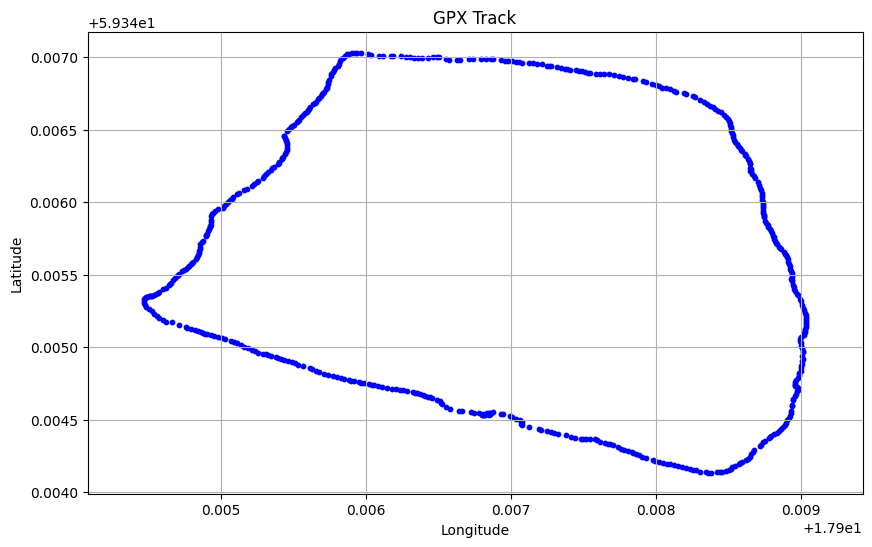

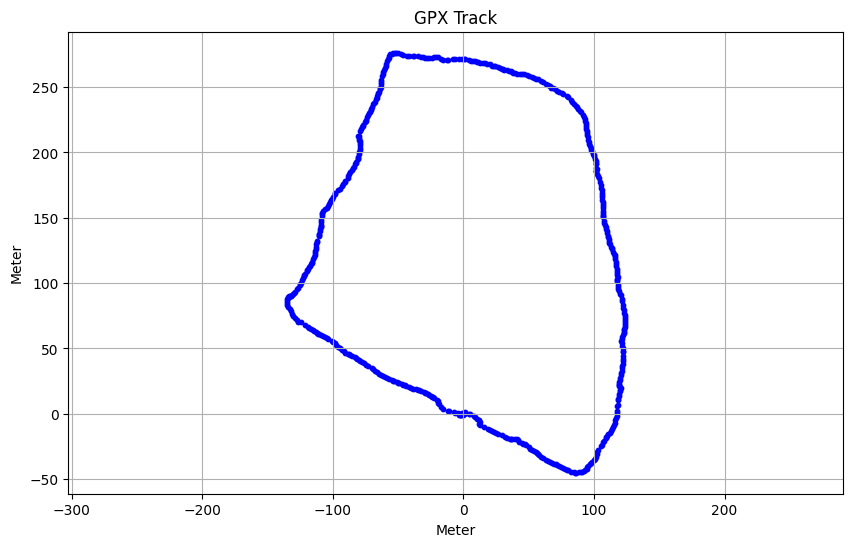

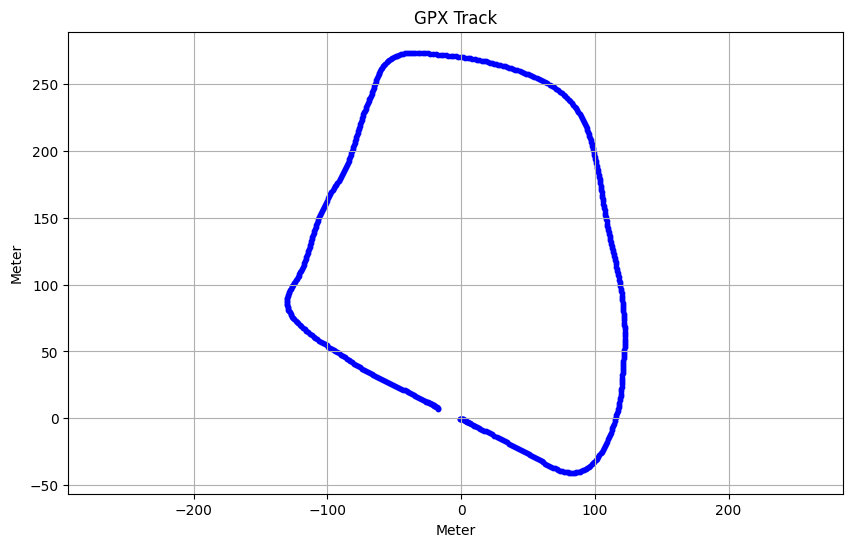

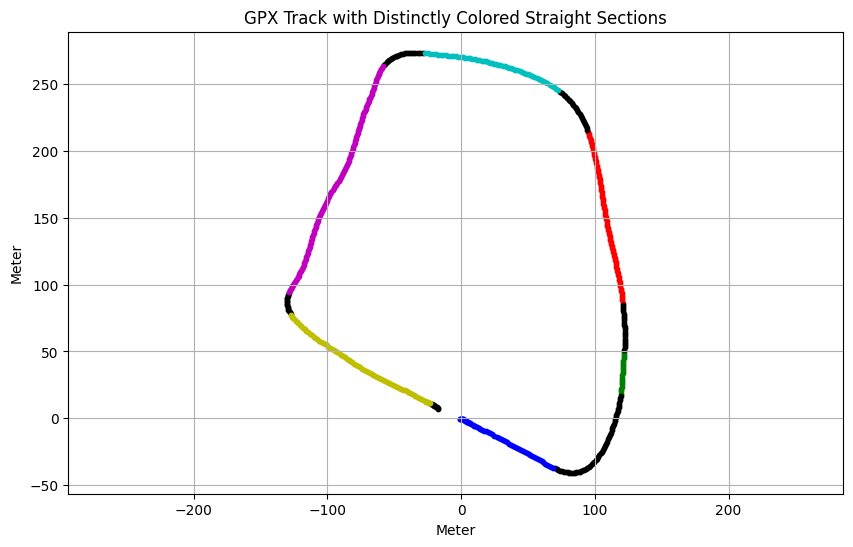

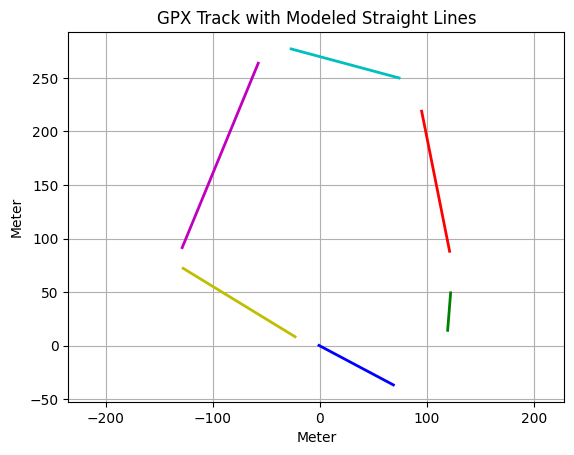

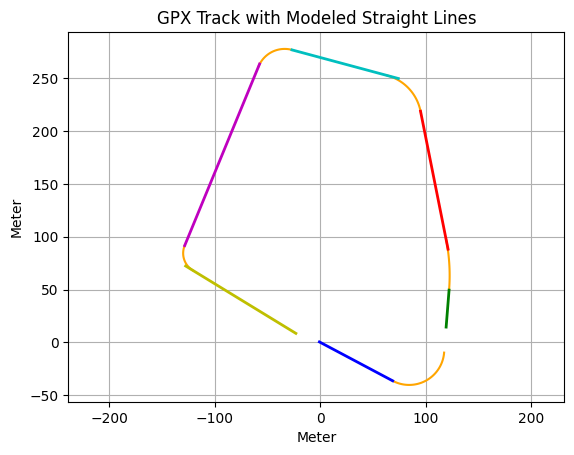

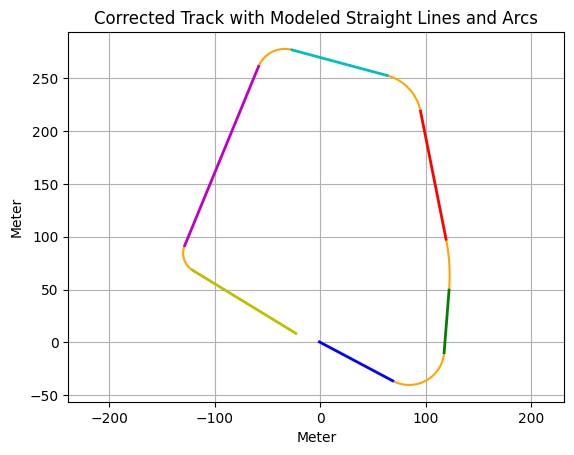

        Type  Section Length  Corner Radius
0   Straight       78.618973       0.000000
1       Left       65.800701      33.234860
2   Straight       59.399507       0.000000
3       Left       48.545348     175.844173
4   Straight      123.609020       0.000000
5       Left       48.870526      43.985691
6   Straight       93.294730       0.000000
7       Left       38.528951      26.710980
8   Straight      183.720491       0.000000
9       Left       26.804729      18.965899
10  Straight      114.536108       0.000000


In [2]:
###################### LIBRAIRIES ######################

import gpxpy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import cycle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sympy import symbols, Eq, solve, atan2, pi
import functions_GPX_to_Excel as f

###################### PARAMETERS ######################

# Import the GPX file
path_GPX = 'Tour_de_quartier.gpx'

# Define the average interval for the moving average filter
average_interval = 30 

# Define the error and the minimum number of points for the regression model
error_threshold = 12e-3
min_points_straight = 20

# Define the path to the csv file
path_csv = 'inner_border.csv'

###################### MAIN CODE ######################

# Get the coordinates from the GPX file
latitudes, longitudes = f.get_gpx(path_GPX)

# Convert the latitudes and longitudes to meters
points = np.array([[longitudes[i], latitudes[i]] for i in range(len(longitudes))])

# Calculate the reference point as the first point in the data
ref_point = points[0]

# Convert all points to meters relative to the reference point
meter_points = [f.latlon_to_meters(lat, lon, ref_point[1], ref_point[0]) for lon, lat in points]
meter_points = np.array(meter_points)

# Plotting the routes in coordinates and meters
f.plot_route(points, condition='coordinates')
f.plot_route(meter_points, condition='meters')

# Smooth the route using a moving average filter
smoothed_points = f.moving_average_filter(meter_points, average_interval)
smoothed_points = np.array(smoothed_points)  # Convert to NumPy array for efficient operations

# Plotting the smoothed route
f.plot_route(smoothed_points, condition='meters')

# Spot straight lines
straight_lines, line_indices = f.spot_straight_lines(smoothed_points, min_points_straight, error_threshold)

# Generate a list of distinct colors for the straight lines
distinct_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'purple', 'pink', 'lime', 'navy']
color_cycler = cycle(distinct_colors)

# Assign a unique color to each straight line for plotting
line_colors = {i: next(color_cycler) for i in range(len(straight_lines))}

# Pre-compute colors for all points
point_colors = np.array([line_colors.get(index, 'k') for index in line_indices])

# Plot the colored route
f.plot_colored_route(point_colors, smoothed_points)

# Get the tangents and endpoints of the straight lines
tangents, line_endpoints = f.get_tagents_and_endpoints(straight_lines)

# Plot the straight lines
f.plot_straight_lines(tangents, line_endpoints, line_colors)

# Compute the arcs
arcs_end, radius, length_arc, arcs = f.compute_arcs(tangents, line_endpoints)
    
# Plot the arcs
for arc in arcs:
    arc_x, arc_y = arc
    plt.plot(arc_x, arc_y, color='orange')
    
# Plot the straight lines
f.plot_straight_lines(tangents, line_endpoints, line_colors)

# Plot the arcs
for arc in arcs:
    arc_x, arc_y = arc
    plt.plot(arc_x, arc_y, color='orange')

# Plot the corrected straight lines
length_straight = f.plot_corrected_straigth_lines(line_endpoints, arcs_end, tangents, line_colors)

# Save the data to a csv file
f.save_dataframe_to_csv(tangents, length_straight, length_arc, radius, path_csv)